# OASIS 2D IMAGES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import matplotlib.image as mpimg
import random


import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Mild Demented

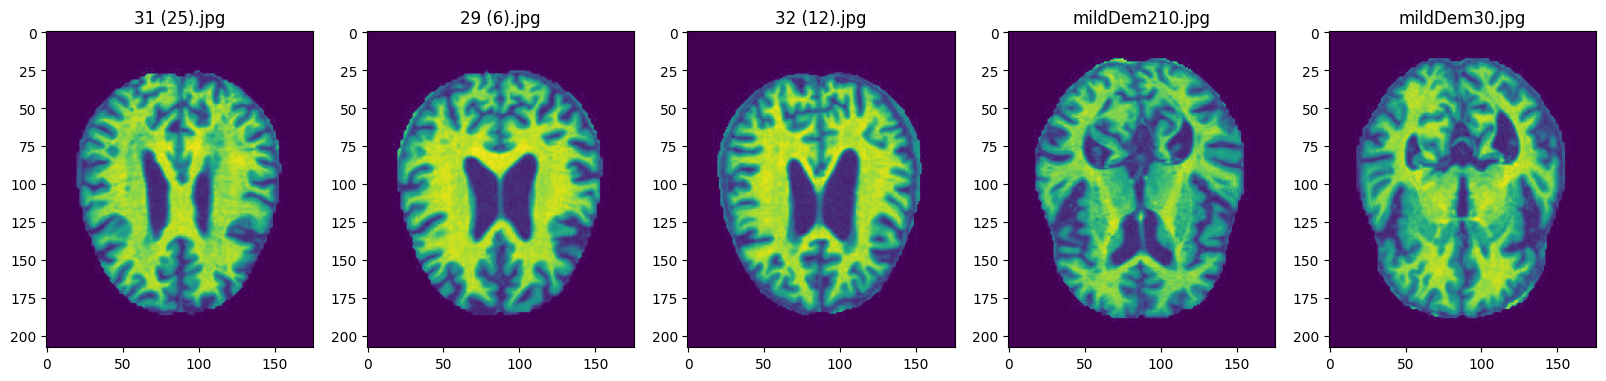

In [3]:

plt.figure(figsize=(20,20))
test_folder=r"/content/drive/MyDrive/Alzheimer_s Dataset/MildDemented"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)



## Moderate Demented

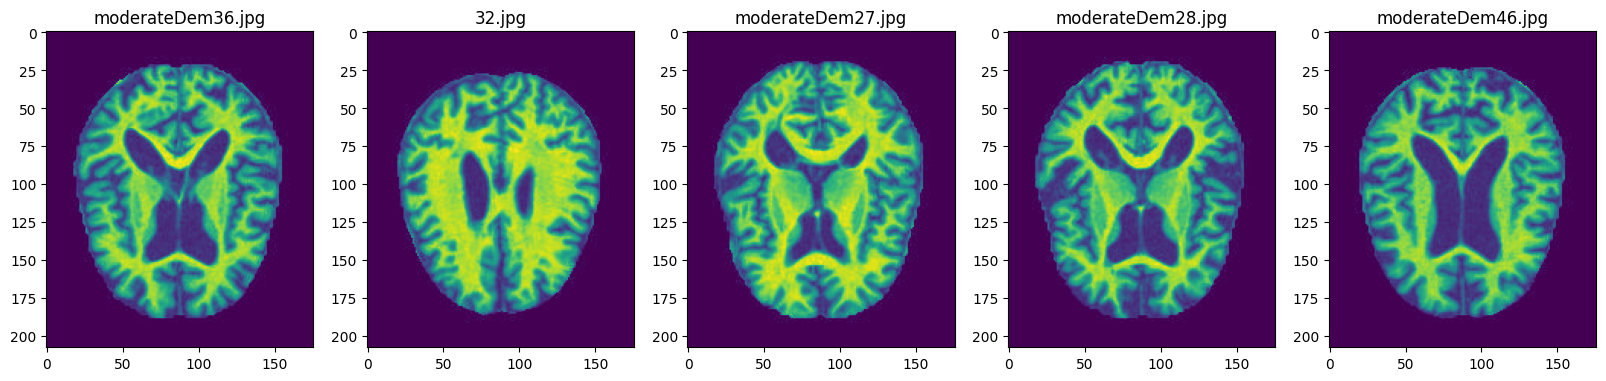

In [4]:
plt.figure(figsize=(20,20))
test_folder=r"/content/drive/MyDrive/Alzheimer_s Dataset/ModerateDemented"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## NonDemented

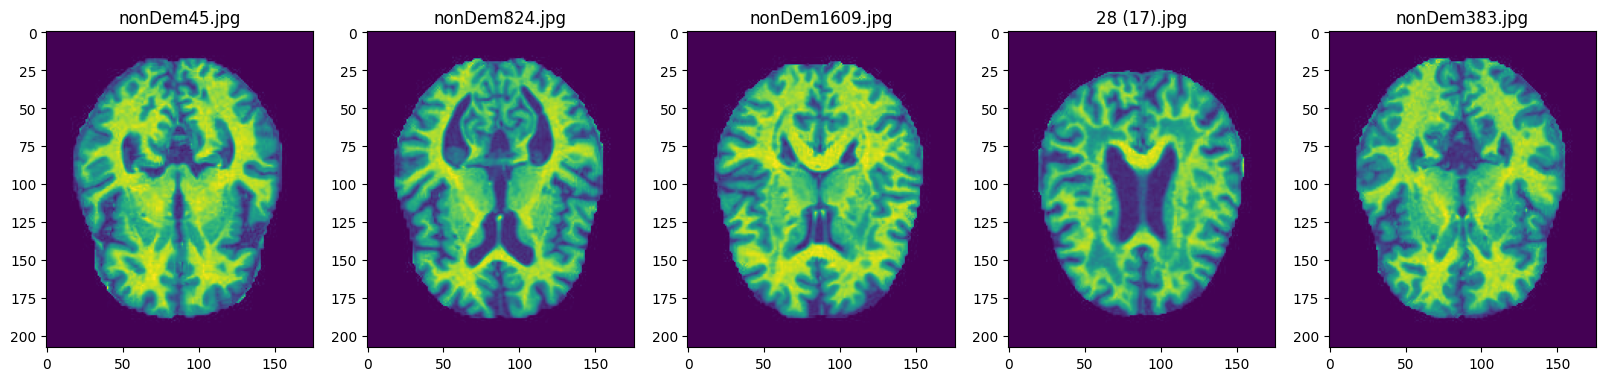

In [5]:
plt.figure(figsize=(20,20))
test_folder=r"/content/drive/MyDrive/Alzheimer_s Dataset/NonDemented"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## Very Mild Demented

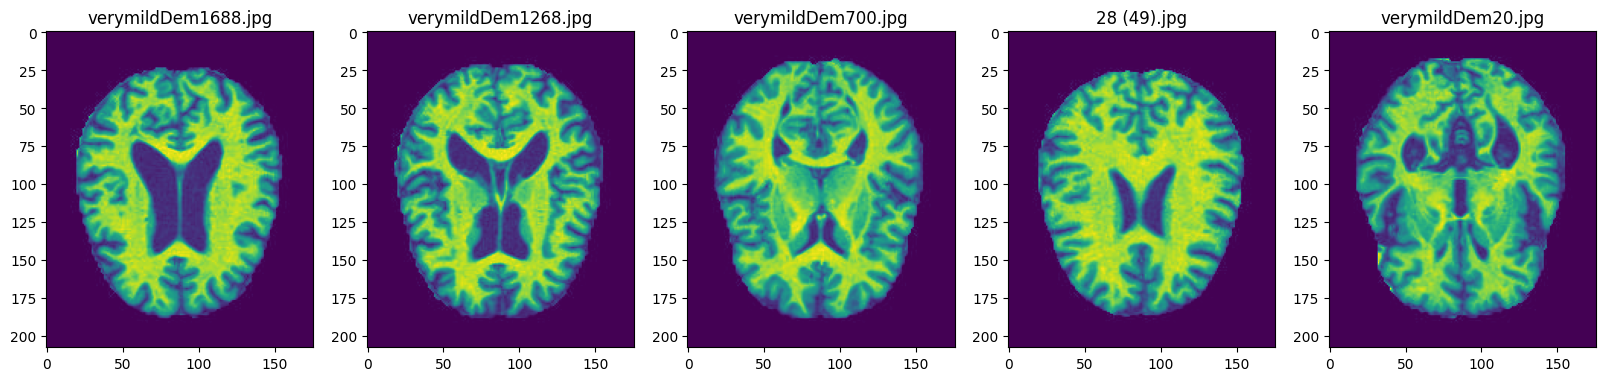

In [6]:
plt.figure(figsize=(20,20))
test_folder=r"/content/drive/MyDrive/Alzheimer_s Dataset/VeryMildDemented"
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## Loading data

In [7]:

BATCH_SIZE = 32
IMG_SIZE = (160, 160)
print("load train data set:")
data_ds = image_dataset_from_directory(r"/content/drive/MyDrive/Alzheimer_s Dataset",
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE,
                                        color_mode="grayscale",
                                        seed=0)
print("load  data set:")



load train data set:
Found 6400 files belonging to 4 classes.
load  data set:


class names are ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


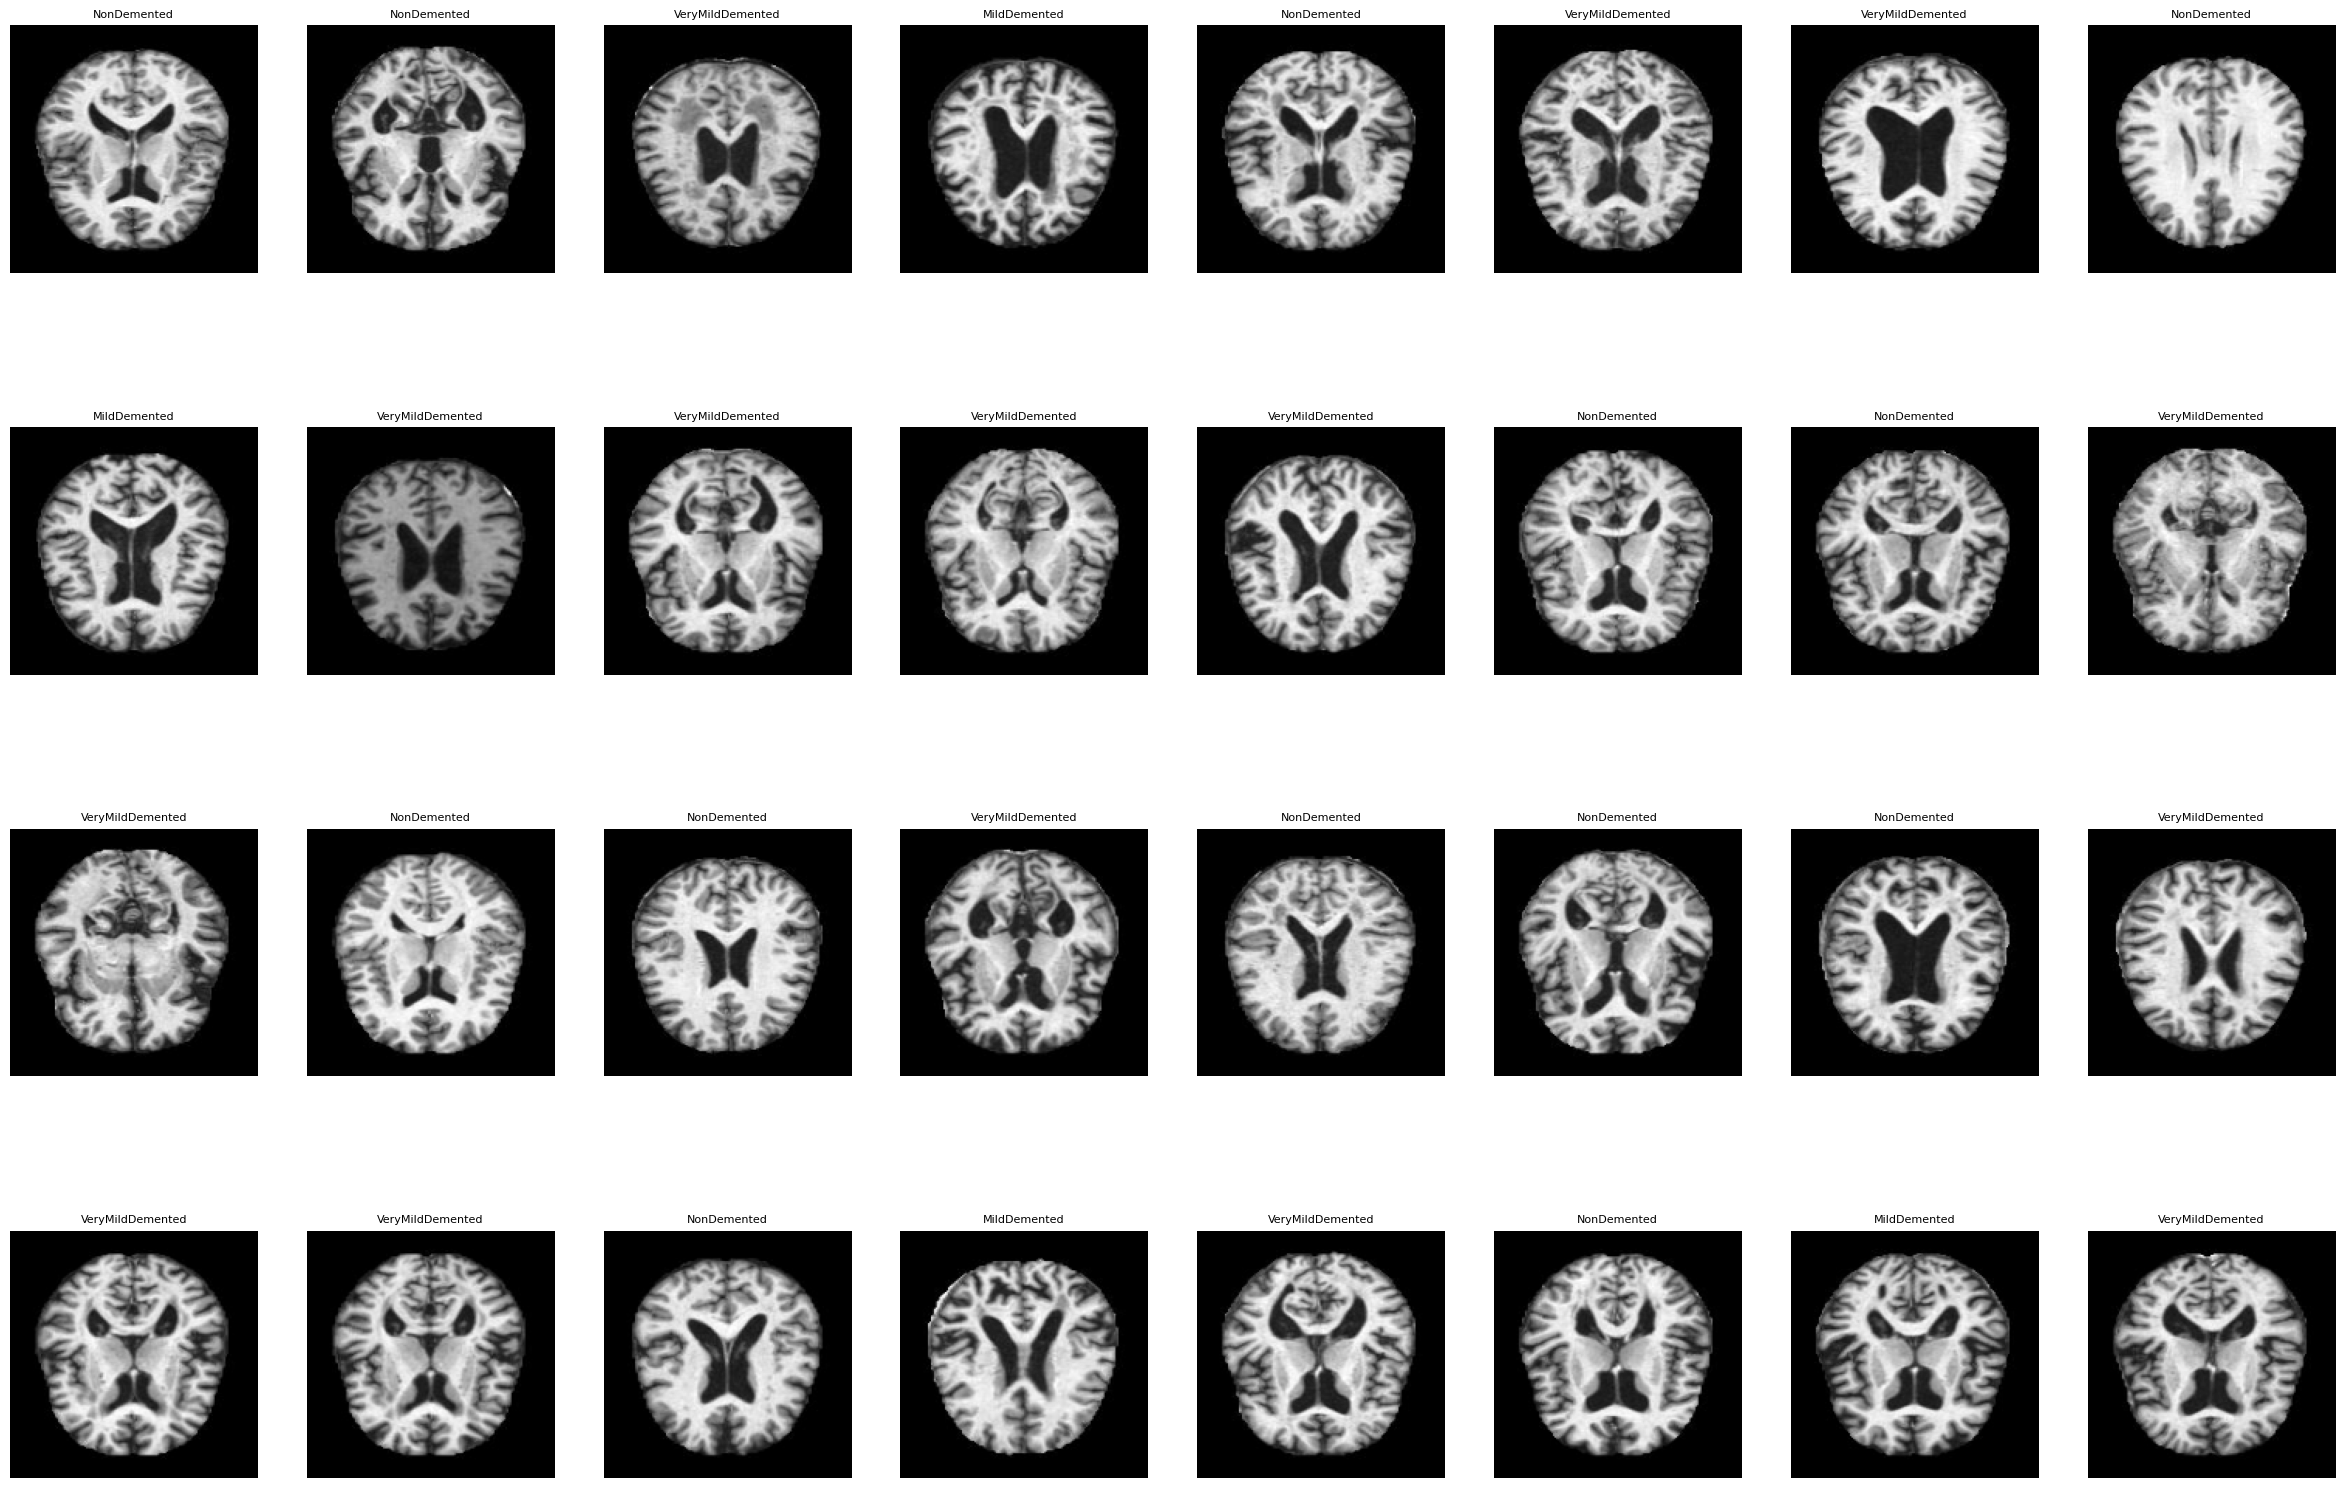

In [8]:


class_names = data_ds.class_names
print(f"class names are {class_names}")
fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(30, 20))
fig.subplots_adjust(wspace=0.2, hspace=0.2)

images, labels = next(iter(data_ds))
for i in range(32):
    a = ax.flat[i]
    a.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    a.set_title(class_names[labels[i]],fontsize = 8)
    a.set_axis_off()





# Distribution

[ 896   64 3200 2240]


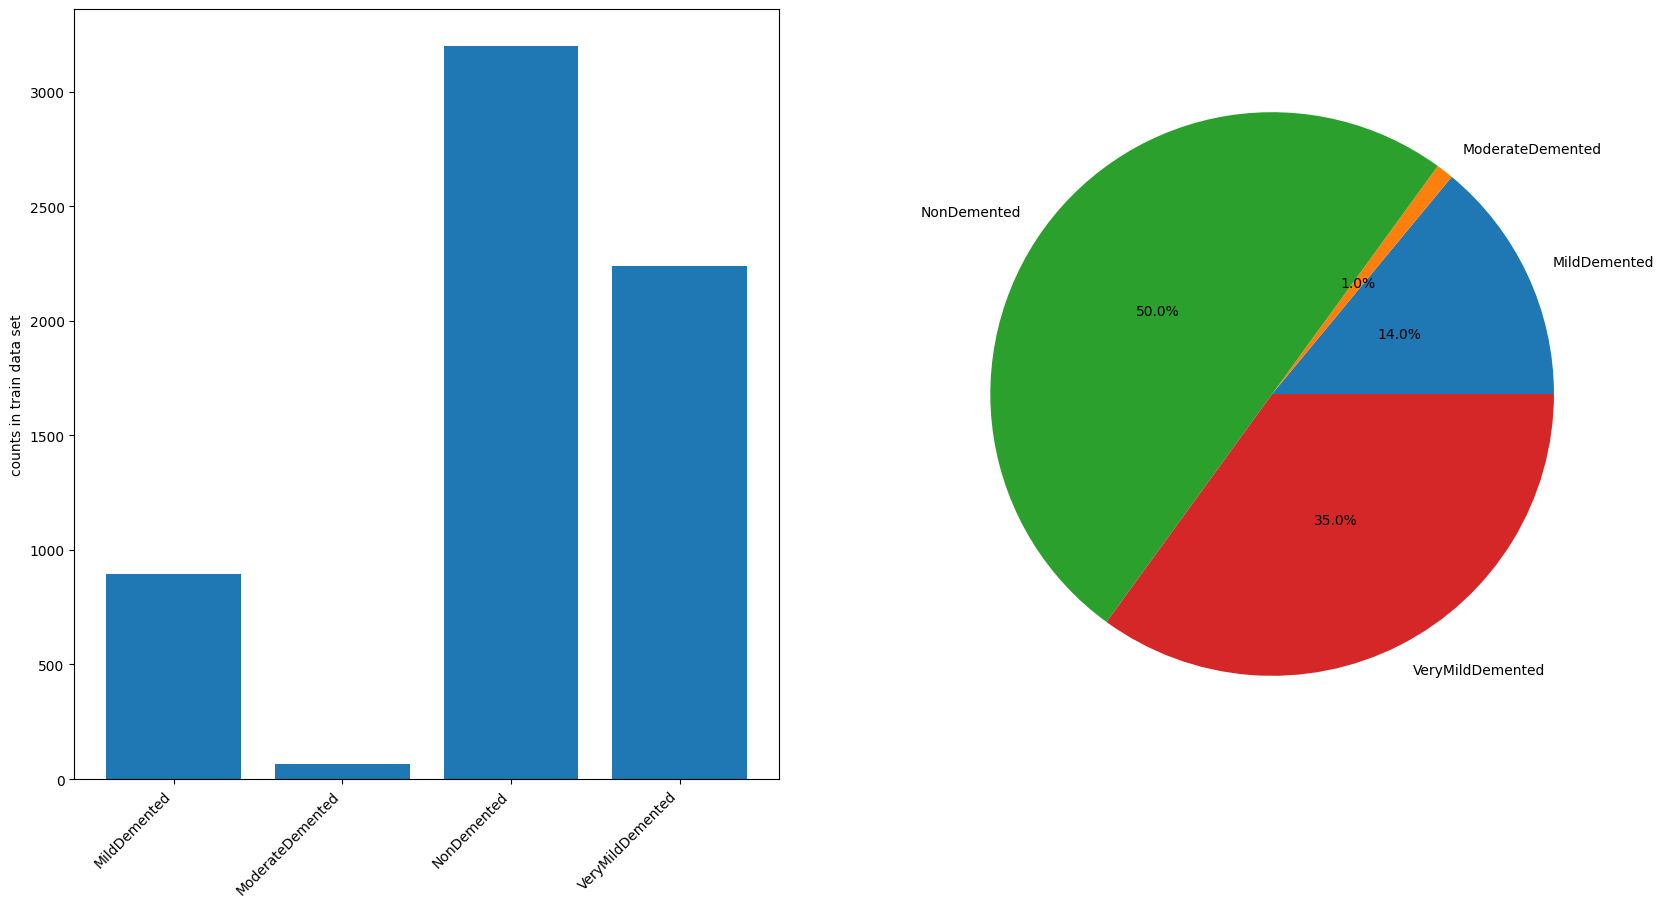

In [9]:


index = np.array([],dtype="int32");
for element in data_ds.as_numpy_iterator():
    index = np.append(index,element[1])

unique, counts = np.unique(index, return_counts=True)
print(counts)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax[0].bar(unique,counts)
ax[0].set_ylabel(f"counts in train data set")
ax[0].set_xticks(np.arange(len(unique)))
ax[0].set_xticklabels([class_names[i] for i in unique], rotation=45, ha='right')

ax[1].pie(counts/counts.sum(), labels=[class_names[i] for i in unique],
          autopct='%1.1f%%',pctdistance=0.5, labeldistance=1.1)


plt.show()



### Data Augmentation


In [10]:

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   )




In [11]:
imag_size = (176,208)

train_dataset  = train_datagen.flow_from_directory(directory = r"/content/drive/MyDrive/Alzheimer_s Dataset",
                                                   shuffle = True,
                                                   target_size = imag_size,
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 6500
                                                  )


train_data, train_labels = train_dataset.next()

print(train_data.shape, train_labels.shape)

Found 6400 images belonging to 4 classes.
(6400, 176, 208, 3) (6400, 4)


In [12]:
sm = SMOTE(random_state=42)
img_s1 = 176
img_s2 = 208

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, img_s1 * img_s2 * 3), train_labels)

train_data = train_data.reshape(-1, img_s1, img_s2, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 208, 3) (12800, 4)


In [13]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

## Model Building - Inception V3

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

import ssl

ssl._create_default_https_context = ssl._create_unverified_context
inception = InceptionV3(input_shape=(img_s1,img_s2,3),
                   include_top=False,
                   weights="imagenet")

for layer in inception.layers:
    layer.trainable=False

x = Flatten()(inception.output)

prediction = Dense(4, activation='softmax')(x)

modelv3 = Model(inputs=inception.input, outputs=prediction)
modelv3.summary()
#plot_model(modelv3)

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 176, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 87, 103, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 87, 103, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                             

### Model Compile

In [15]:



import tensorflow
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRIC = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),]

modelv3.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)


earlystopping = EarlyStopping(verbose = 1, patience = 40)


callback_list = [earlystopping]


In [16]:


model_history=modelv3.fit(train_data, train_labels,
                        validation_data= (val_data, val_labels),
                        epochs = 50, callbacks = callback_list,
                        )



Epoch 1/50
256/256 [==============================] - 75s 270ms/step - loss: 2.6153 - accuracy: 0.7822 - precision: 0.5658 - recall: 0.5530 - auc: 0.7843 - val_loss: 1.2342 - val_accuracy: 0.8411 - val_precision: 0.6854 - val_recall: 0.6733 - val_auc: 0.8857
Epoch 2/50
256/256 [==============================] - 71s 279ms/step - loss: 1.3611 - accuracy: 0.8531 - precision: 0.7094 - recall: 0.6989 - auc: 0.8879 - val_loss: 1.9321 - val_accuracy: 0.8304 - val_precision: 0.6626 - val_recall: 0.6558 - val_auc: 0.8456
Epoch 3/50
256/256 [==============================] - 74s 290ms/step - loss: 1.3819 - accuracy: 0.8659 - precision: 0.7339 - recall: 0.7272 - auc: 0.8949 - val_loss: 1.9820 - val_accuracy: 0.8486 - val_precision: 0.6986 - val_recall: 0.6938 - val_auc: 0.8607
Epoch 4/50
256/256 [==============================] - 69s 269ms/step - loss: 1.3612 - accuracy: 0.8795 - precision: 0.7603 - recall: 0.7565 - auc: 0.9046 - val_loss: 1.5990 - val_accuracy: 0.8599 - val_precision: 0.7204 - v

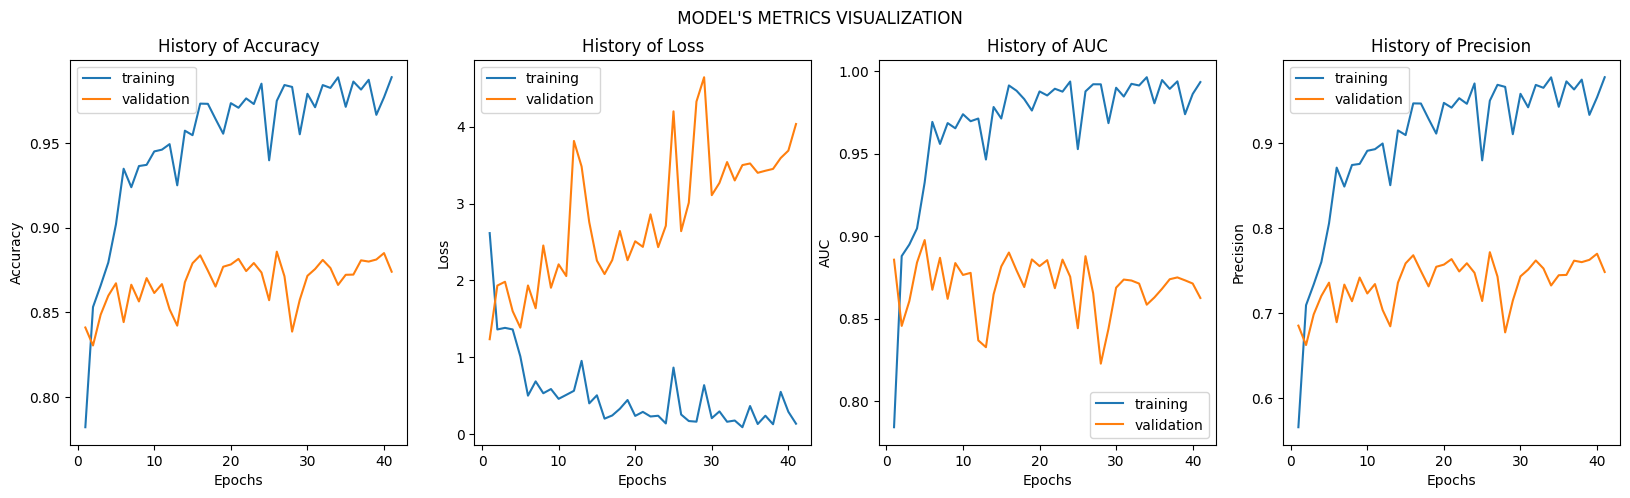

In [17]:



def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):

    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])



    plt.show()


Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision'],

              )






### Prediction and Metrics

80/80 [==============================] - 16s 189ms/step


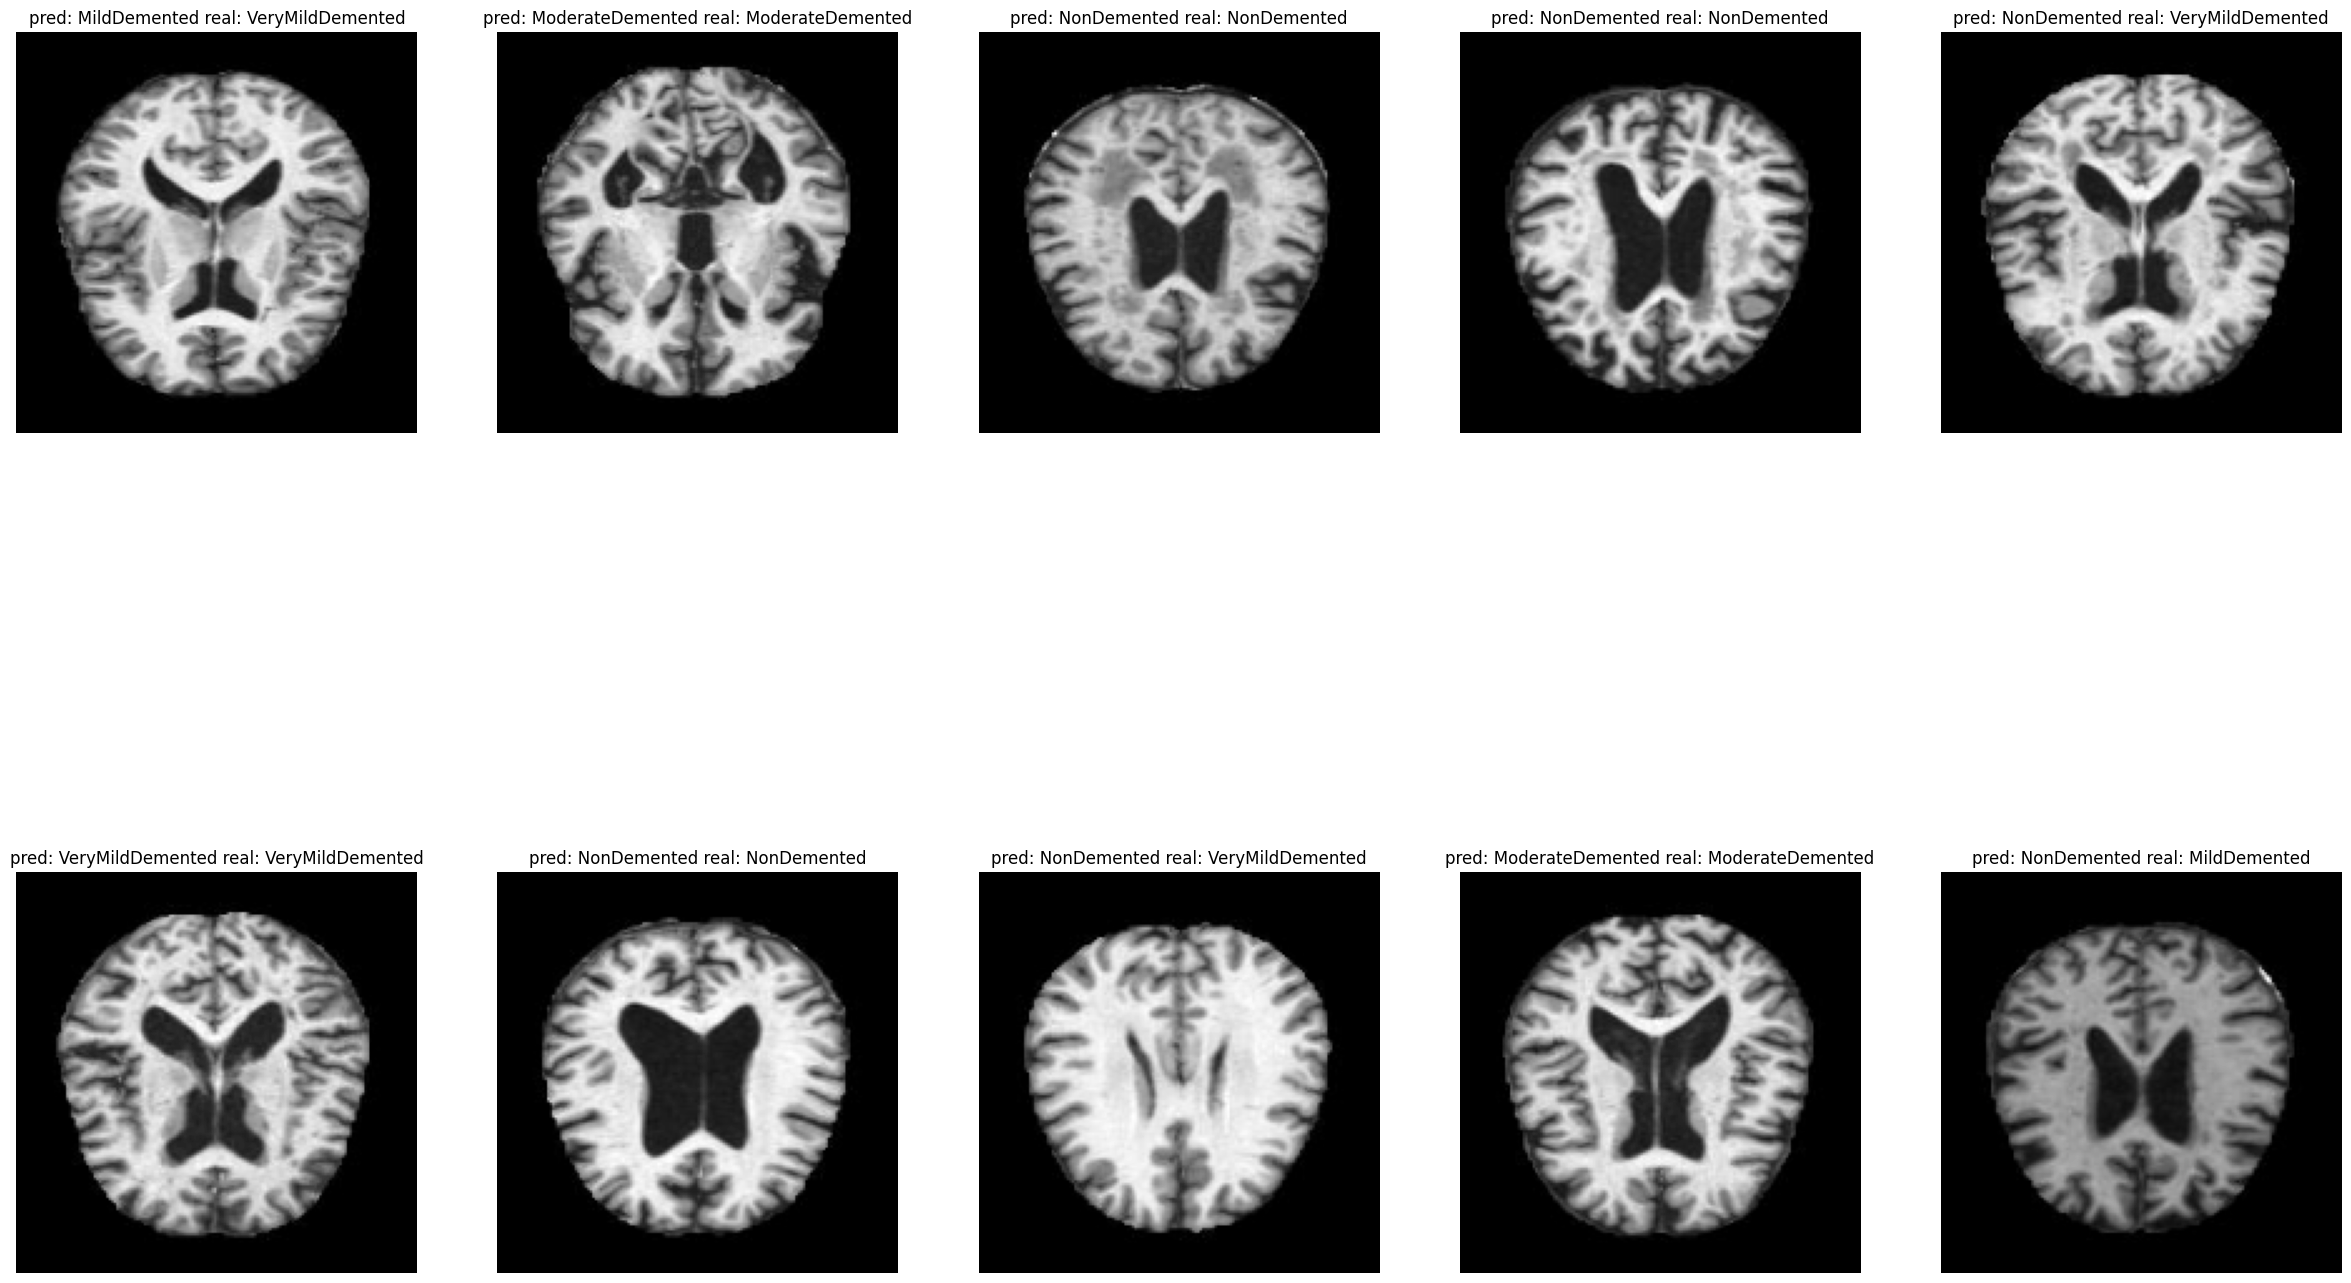

In [18]:
pred_labels= modelv3.predict(test_data)

def roundoff(arr):
  """To round off according to the argmax of each predicted label array. """
  arr[np.argwhere(arr != arr.max())] = 0
  arr[np.argwhere(arr == arr.max())] = 1
  return arr

for labels in pred_labels:
    labels = roundoff(labels)


y_pred = np.argmax(pred_labels, axis=1)
y_test =  np.argmax(test_labels, axis=1)


fig, ax = plt.subplots(nrows=2, ncols=5,figsize=(30, 20))
fig.subplots_adjust(wspace=0.2, hspace=0.2)


for i in range(10):
    a = ax.flat[i]
    a.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    pred_label=y_pred[i]
    actual_label=y_test[i]
    pred_label=class_names[pred_label]
    actual_label=class_names[actual_label]
    label= 'pred: '+ pred_label +' '+'real: '+ actual_label
    a.set_title(label)
    a.set_axis_off()

plt.show()



In [19]:


scores = modelv3.evaluate(test_data, test_labels)


80/80 [==============================] - 15s 188ms/step - loss: 3.8556 - accuracy: 0.8742 - precision: 0.7486 - recall: 0.7480 - auc: 0.8631


In [20]:

print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])



Accuracy =  0.874218761920929
Precision =  0.7486317157745361
Recall =  0.748046875
AUC =  0.8631334900856018


In [21]:

from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test, target_names=class_names))

                  precision    recall  f1-score   support

    MildDemented       0.76      0.79      0.77       606
ModerateDemented       1.00      0.98      0.99       652
     NonDemented       0.81      0.59      0.68       870
VeryMildDemented       0.44      0.67      0.53       432

        accuracy                           0.75      2560
       macro avg       0.75      0.75      0.74      2560
    weighted avg       0.78      0.75      0.76      2560



### Confusion matrix

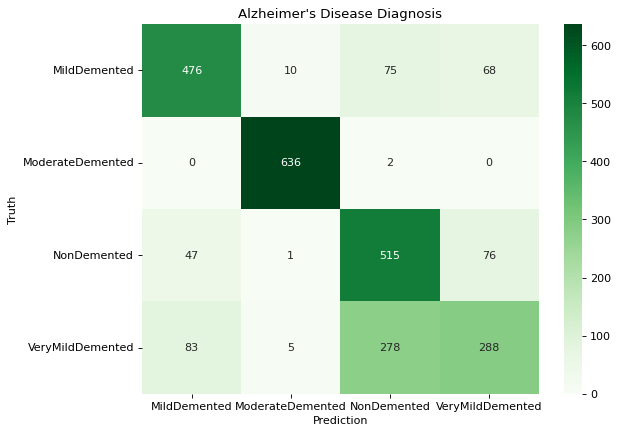

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_arr = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= class_names,
                yticklabels=class_names)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)



## Model Building - ResNet50

---






In [23]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
from tensorflow.keras.applications.resnet50 import ResNet50

res = ResNet50(input_shape=(img_s1,img_s2,3),
                   include_top=False,
                   weights="imagenet")

for layer in res.layers:
    layer.trainable=False

x = Flatten()(res.output)

prediction = Dense(4, activation='softmax')(x)

res50 = Model(inputs=res.input, outputs=prediction)
res50.summary()
#plot_model(res50)


94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 176, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 182, 214, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 88, 104, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizati

### Model Compile

In [24]:



import tensorflow
OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
METRIC = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),]

res50.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)


earlystopping = EarlyStopping(
                              patience = 15,
                              verbose = 1)


callback_list = [earlystopping]


In [25]:


model_history=res50.fit(train_data, train_labels,
                        validation_data= (val_data, val_labels),
                        epochs = 50, callbacks = callback_list,
                        )



Epoch 1/50
256/256 [==============================] - 150s 572ms/step - loss: 2.0623 - accuracy: 0.7164 - precision: 0.4125 - recall: 0.3165 - auc: 0.6524 - val_loss: 1.1555 - val_accuracy: 0.7570 - val_precision: 0.5254 - val_recall: 0.2876 - val_auc: 0.7535
Epoch 2/50
256/256 [==============================] - 140s 549ms/step - loss: 1.3372 - accuracy: 0.7576 - precision: 0.5194 - recall: 0.4076 - auc: 0.7438 - val_loss: 1.4242 - val_accuracy: 0.7179 - val_precision: 0.4331 - val_recall: 0.4160 - val_auc: 0.7384
Epoch 3/50
256/256 [==============================] - 142s 554ms/step - loss: 1.4141 - accuracy: 0.7626 - precision: 0.5297 - recall: 0.4480 - auc: 0.7566 - val_loss: 1.8067 - val_accuracy: 0.7556 - val_precision: 0.5123 - val_recall: 0.4688 - val_auc: 0.7307
Epoch 4/50
256/256 [==============================] - 131s 513ms/step - loss: 1.1644 - accuracy: 0.7878 - precision: 0.5902 - recall: 0.4943 - auc: 0.8048 - val_loss: 0.9881 - val_accuracy: 0.8047 - val_precision: 0.6271

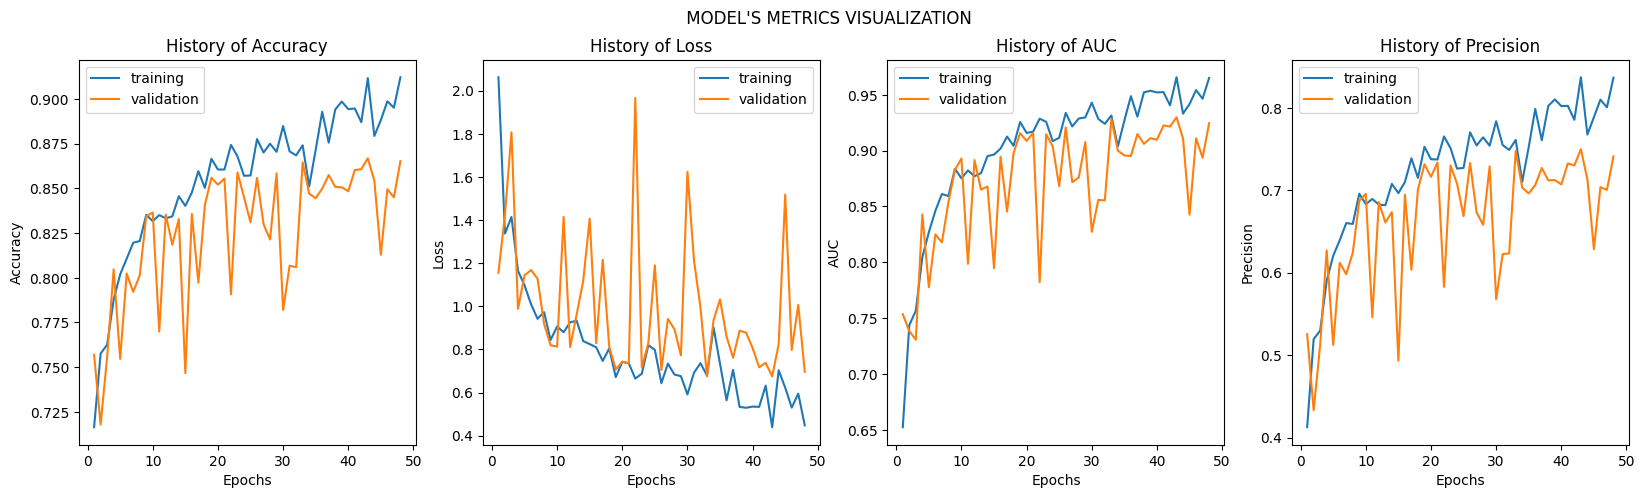

In [26]:




def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):

    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])



    plt.show()


Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision'],

              )






### Prediction and Metrics

80/80 [==============================] - 37s 445ms/step


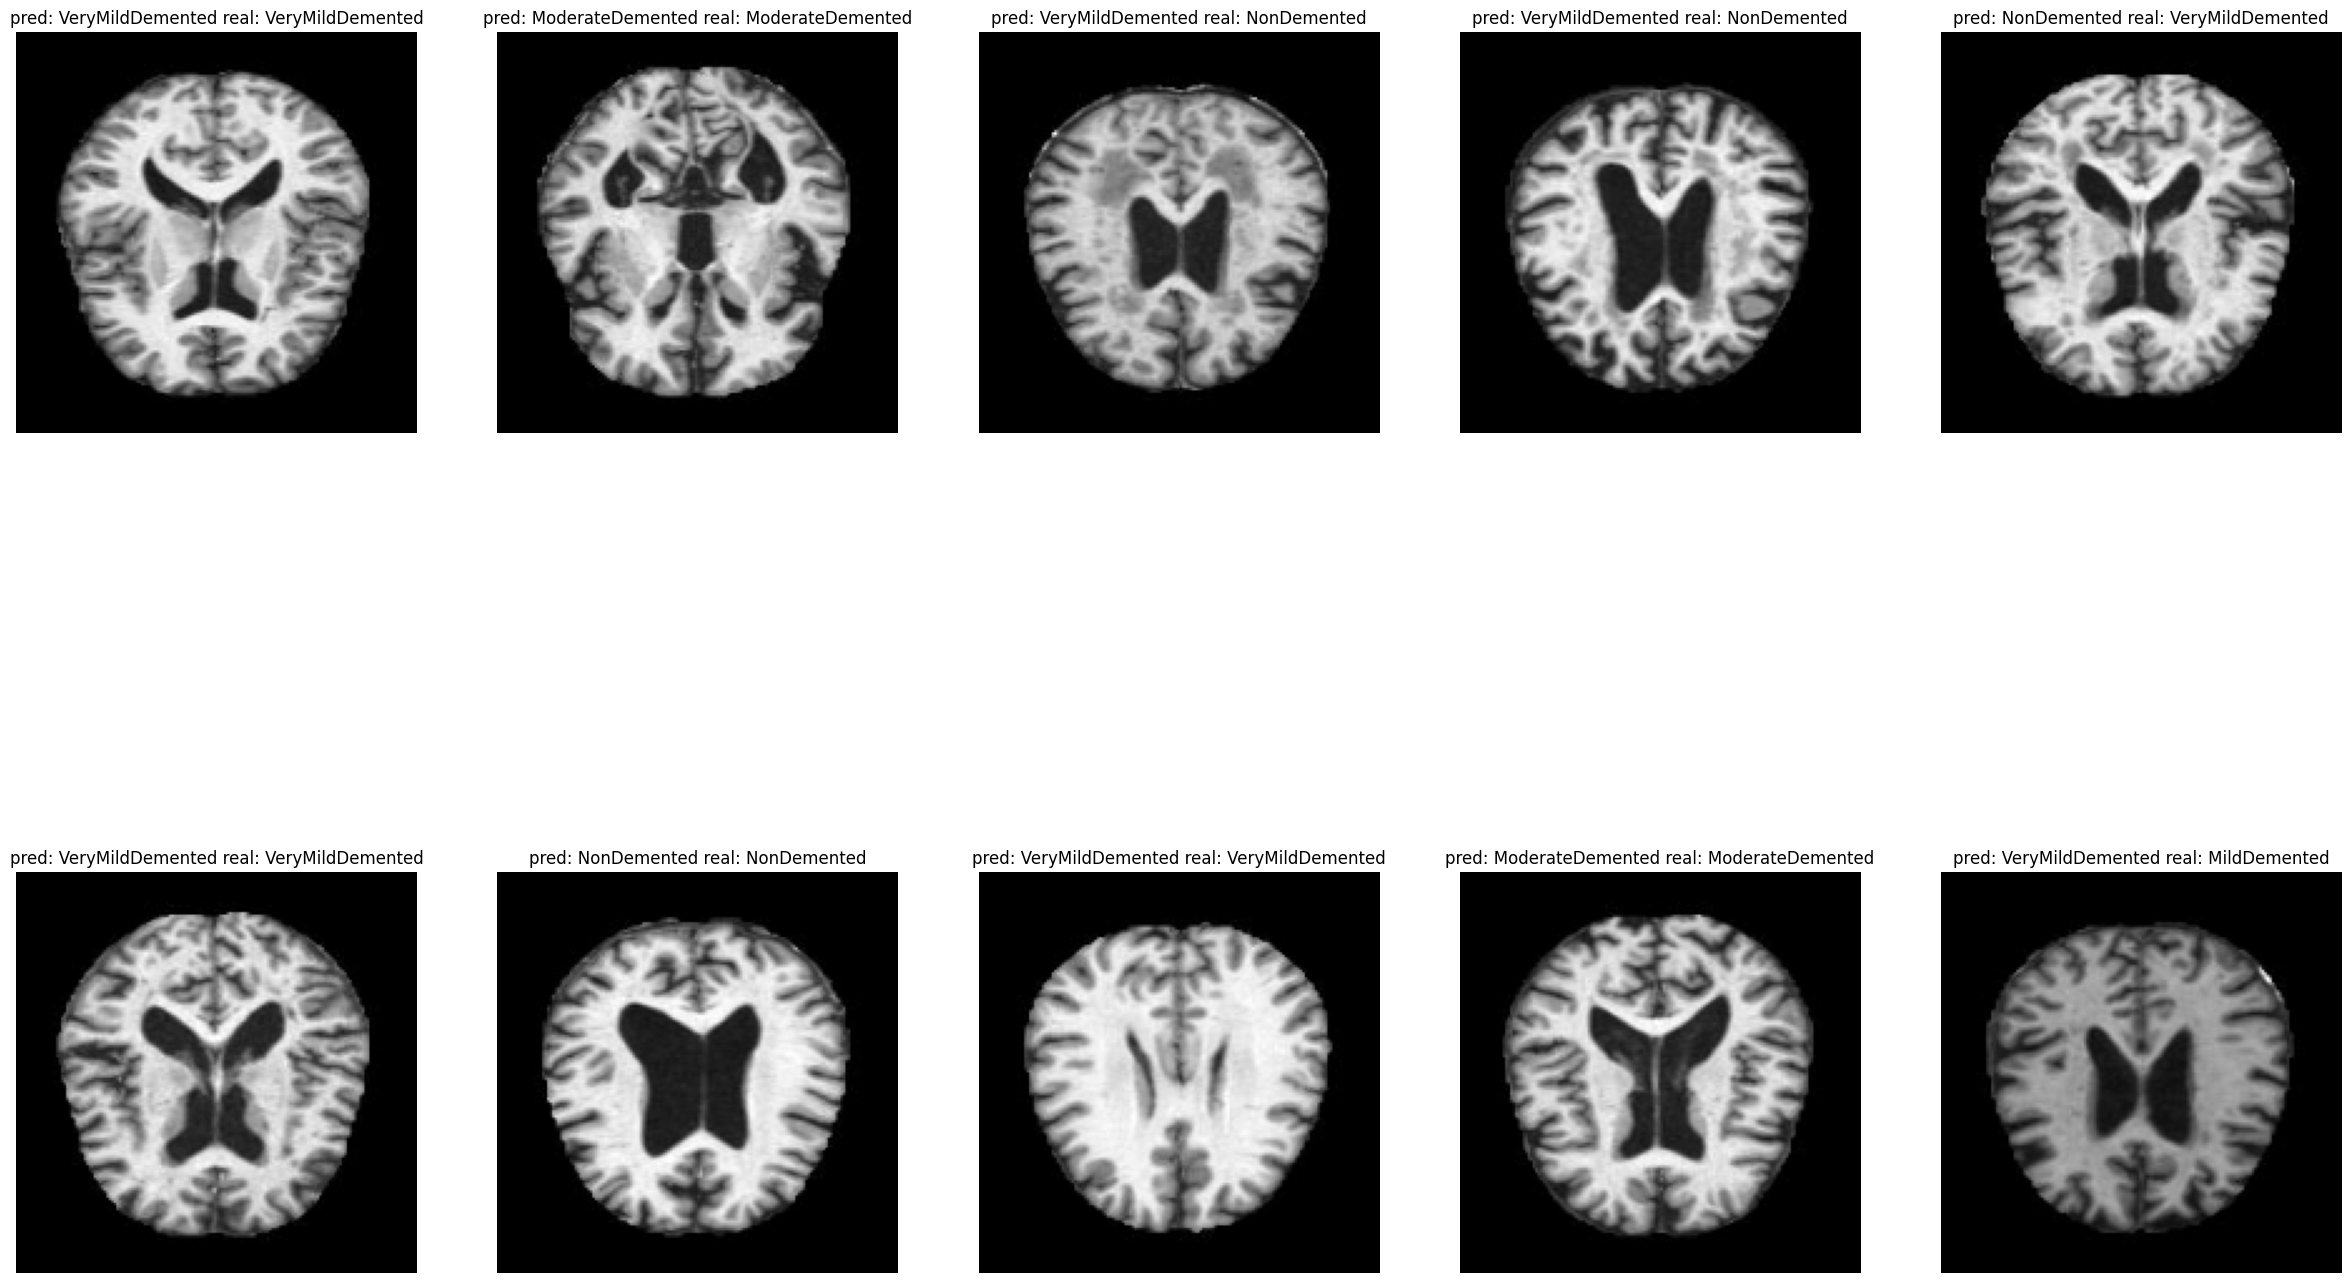

In [27]:
pred_labels= res50.predict(test_data)

def roundoff(arr):
  """To round off according to the argmax of each predicted label array. """
  arr[np.argwhere(arr != arr.max())] = 0
  arr[np.argwhere(arr == arr.max())] = 1
  return arr

for labels in pred_labels:
    labels = roundoff(labels)


y_pred = np.argmax(pred_labels, axis=1)
y_test =  np.argmax(test_labels, axis=1)


fig, ax = plt.subplots(nrows=2, ncols=5,figsize=(30, 20))
fig.subplots_adjust(wspace=0.2, hspace=0.2)


for i in range(10):
    a = ax.flat[i]
    a.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    pred_label=y_pred[i]
    actual_label=y_test[i]
    pred_label=class_names[pred_label]
    actual_label=class_names[actual_label]
    label= 'pred: '+ pred_label +' '+'real: '+ actual_label
    a.set_title(label)
    a.set_axis_off()

plt.show()



In [28]:


scores = res50.evaluate(test_data, test_labels)


80/80 [==============================] - 33s 411ms/step - loss: 0.6809 - accuracy: 0.8667 - precision: 0.7450 - recall: 0.7098 - auc: 0.9265


In [29]:

print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])



Accuracy =  0.86669921875
Precision =  0.7449774742126465
Recall =  0.709765613079071
AUC =  0.9264542460441589


In [30]:

from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test, target_names=class_names))

                  precision    recall  f1-score   support

    MildDemented       0.66      0.80      0.72       519
ModerateDemented       0.99      1.00      0.99       632
     NonDemented       0.71      0.60      0.65       754
VeryMildDemented       0.55      0.55      0.55       655

        accuracy                           0.73      2560
       macro avg       0.73      0.74      0.73      2560
    weighted avg       0.73      0.73      0.72      2560



### Confusion matrix

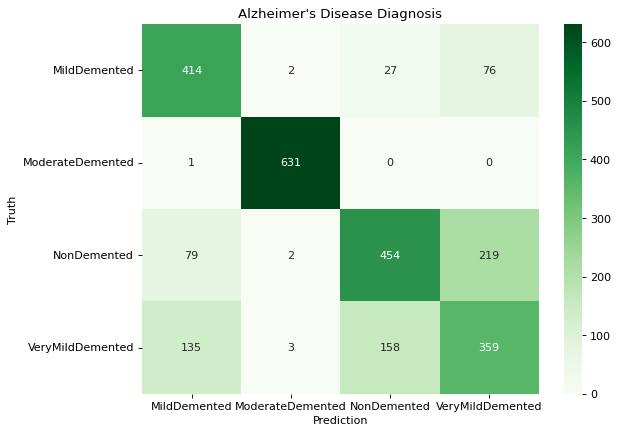

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_arr = confusion_matrix(y_pred, y_test)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= class_names,
                yticklabels=class_names)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)



## Model Building - VGG19

In [32]:
vgg = VGG19(input_shape=(176,208,3),
                   include_top=False,
                   weights="imagenet")

for layer in vgg.layers:
    layer.trainable=False

x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=vgg.input, outputs=prediction)
modelvgg.summary()
#plot_model(modelvgg)

80134624/80134624 [==============================] - 0s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                            

### Model Compile

In [33]:



import tensorflow
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRIC = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),]

modelvgg.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)


earlystopping = EarlyStopping(patience = 40)


callback_list = [earlystopping]


In [34]:


model_history=modelvgg.fit(train_data, train_labels,
                        validation_data= (val_data, val_labels),
                        epochs = 50, callbacks = callback_list,
                        )



Epoch 1/50
256/256 [==============================] - 312s 1s/step - loss: 1.0326 - accuracy: 0.7977 - precision: 0.6444 - recall: 0.4258 - auc: 0.8109 - val_loss: 0.8291 - val_accuracy: 0.8303 - val_precision: 0.7109 - val_recall: 0.5415 - val_auc: 0.8770
Epoch 2/50
256/256 [==============================] - 312s 1s/step - loss: 0.7440 - accuracy: 0.8475 - precision: 0.7439 - recall: 0.5950 - auc: 0.9027 - val_loss: 0.9416 - val_accuracy: 0.8243 - val_precision: 0.6640 - val_recall: 0.6021 - val_auc: 0.8726
Epoch 3/50
256/256 [==============================] - 313s 1s/step - loss: 0.6394 - accuracy: 0.8709 - precision: 0.7837 - recall: 0.6680 - auc: 0.9283 - val_loss: 0.6205 - val_accuracy: 0.8730 - val_precision: 0.7940 - val_recall: 0.6646 - val_auc: 0.9327
Epoch 4/50
256/256 [==============================] - 312s 1s/step - loss: 0.5433 - accuracy: 0.8874 - precision: 0.8164 - recall: 0.7091 - auc: 0.9494 - val_loss: 0.5779 - val_accuracy: 0.8811 - val_precision: 0.8083 - val_recal

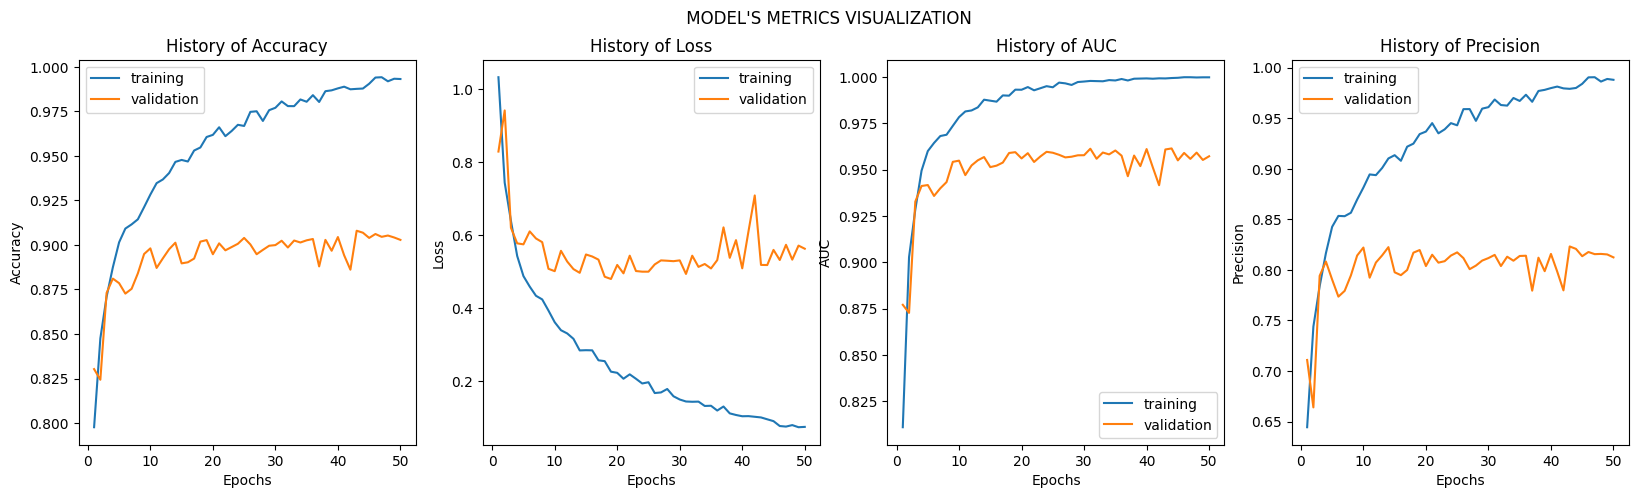

In [35]:


def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):

    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])



    plt.show()


Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
               model_history.history['precision'],model_history.history['val_precision'],

              )






### Prediction and Metrics

80/80 [==============================] - 77s 960ms/step


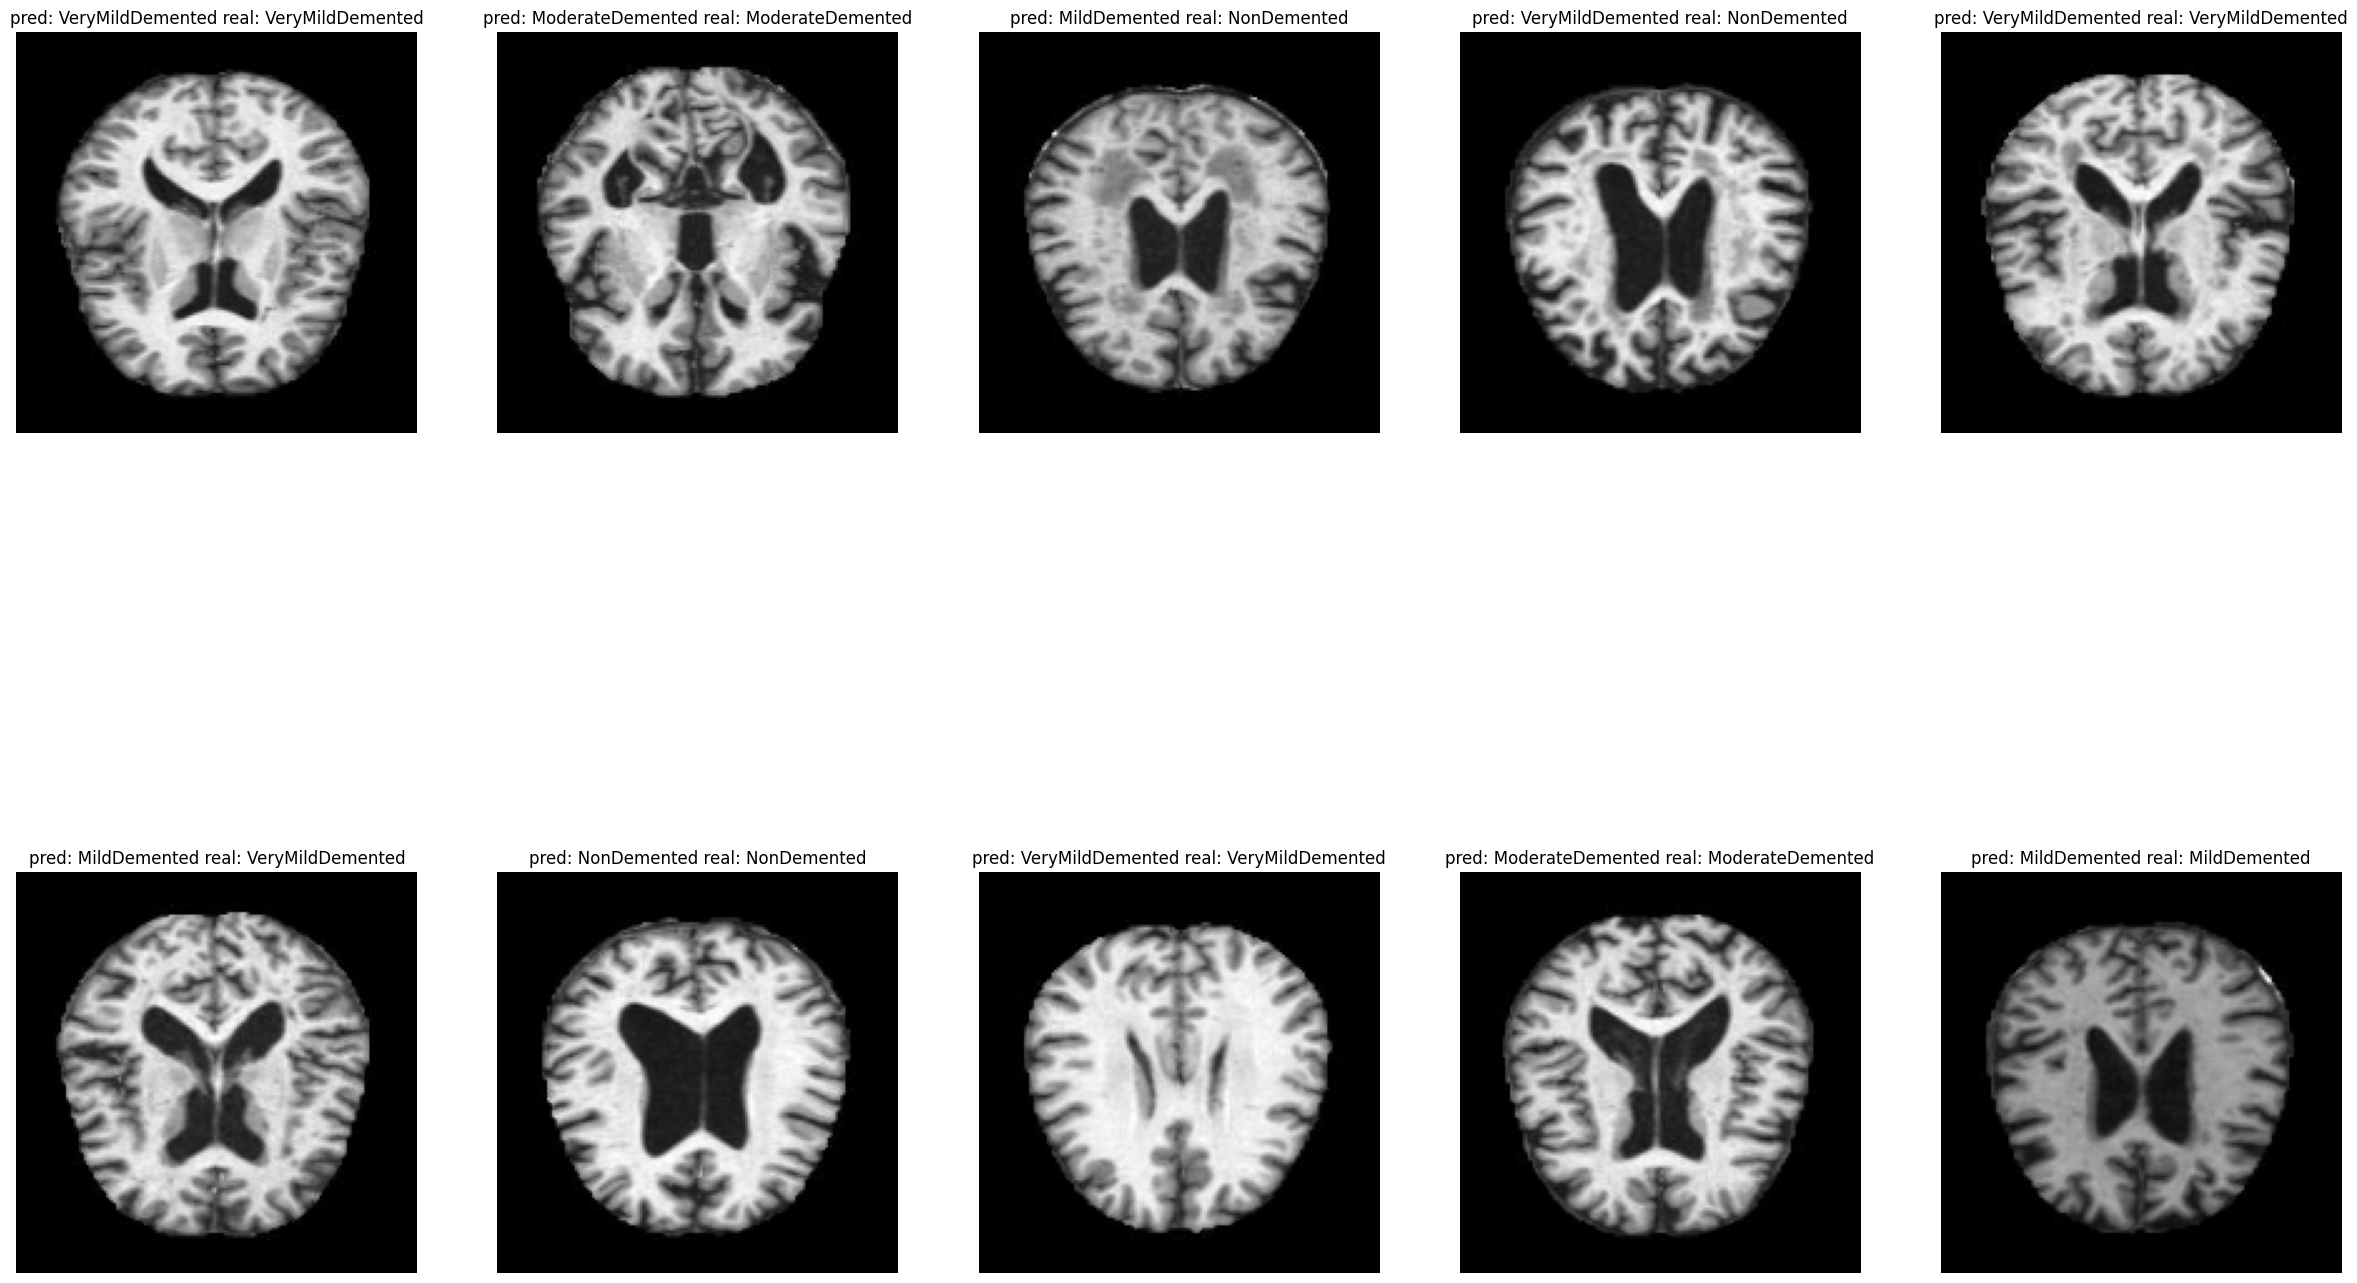

In [36]:
pred_labels= modelvgg.predict(test_data)

def roundoff(arr):
  """To round off according to the argmax of each predicted label array. """
  arr[np.argwhere(arr != arr.max())] = 0
  arr[np.argwhere(arr == arr.max())] = 1
  return arr

for labels in pred_labels:
    labels = roundoff(labels)


y_pred = np.argmax(pred_labels, axis=1)
y_test =  np.argmax(test_labels, axis=1)


fig, ax = plt.subplots(nrows=2, ncols=5,figsize=(30, 20))
fig.subplots_adjust(wspace=0.2, hspace=0.2)


for i in range(10):
    a = ax.flat[i]
    a.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    pred_label=y_pred[i]
    actual_label=y_test[i]
    pred_label=class_names[pred_label]
    actual_label=class_names[actual_label]
    label= 'pred: '+ pred_label +' '+'real: '+ actual_label
    a.set_title(label)
    a.set_axis_off()

plt.show()


In [37]:


scores = modelvgg.evaluate(test_data, test_labels)


80/80 [==============================] - 77s 956ms/step - loss: 0.6761 - accuracy: 0.8911 - precision: 0.7882 - recall: 0.7719 - auc: 0.9432


In [38]:

print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])



Accuracy =  0.89111328125
Precision =  0.7881930470466614
Recall =  0.7718750238418579
AUC =  0.9431648850440979


In [39]:

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))

                  precision    recall  f1-score   support

    MildDemented       0.76      0.88      0.82       629
ModerateDemented       0.99      1.00      0.99       638
     NonDemented       0.72      0.63      0.67       639
VeryMildDemented       0.63      0.62      0.62       654

        accuracy                           0.78      2560
       macro avg       0.78      0.78      0.78      2560
    weighted avg       0.78      0.78      0.78      2560



### Confusion matrix

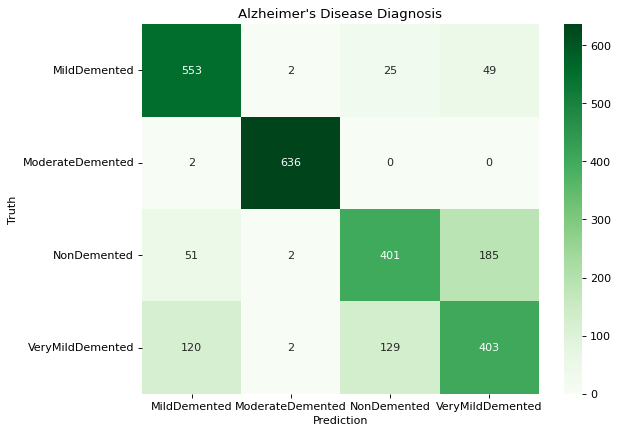

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_arr = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= class_names,
                yticklabels=class_names)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

